In [1]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
def parse_xml(xml_file):
    """Parse le fichier XML pour extraire les coordonnées des boîtes englobantes et la taille originale de l'image."""
    tree = ET.parse(xml_file)
    root = tree.getroot()
    boxes = []
    
    # Extraire la taille originale de l'image
    width = int(root.find('size/width').text)
    height = int(root.find('size/height').text)
    original_size = (width, height)
    
    for obj in root.iter('object'):
        xmin = int(obj.find('bndbox/xmin').text)
        ymin = int(obj.find('bndbox/ymin').text)
        xmax = int(obj.find('bndbox/xmax').text)
        ymax = int(obj.find('bndbox/ymax').text)
        boxes.append([xmin, ymin, xmax, ymax])
    
    return boxes, original_size

In [3]:
def adjust_and_normalize_boxes(boxes, original_size, target_size=(256, 256)):
    """
    Ajuste et normalise les coordonnées des boîtes englobantes.

    :param boxes: Un tableau de boîtes englobantes avec les coordonnées (xmin, ymin, xmax, ymax).
    :param original_size: La taille originale de l'image (largeur, hauteur).
    :param target_size: La taille cible de l'image après redimensionnement.
    :return: Un tableau de boîtes englobantes ajustées et normalisées.
    """
    adjusted_boxes = []
    scale_x = target_size[0] / original_size[0]
    scale_y = target_size[1] / original_size[1]

    for box in boxes:
        xmin, ymin, xmax, ymax = box
        xmin_adj = xmin * scale_x / target_size[0]
        ymin_adj = ymin * scale_y / target_size[1]
        xmax_adj = xmax * scale_x / target_size[0]
        ymax_adj = ymax * scale_y / target_size[1]
        adjusted_boxes.append([xmin_adj, ymin_adj, xmax_adj, ymax_adj])

    return np.array(adjusted_boxes)

In [4]:
def load_images_and_boxes(image_dir, xml_dir, target_size=(256, 256)):
    images = []
    boxes = []

    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        xml_path = os.path.join(xml_dir, image_file.replace('.png', '.xml'))

        # Lire l'image et la redimensionner
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.resize(image, target_size)

        # Extraire les boîtes englobantes et la taille originale de l'image à partir du XML
        box, original_size = parse_xml(xml_path)
        adjusted_boxes = adjust_and_normalize_boxes(box, original_size, target_size)

        images.append(image)
        boxes.append(adjusted_boxes)

    return np.array(images), np.array(boxes)


In [5]:
def normalize_to_absolute_boxes(normalized_boxes, target_size=(256, 256)):
    """
    Convertit des boîtes englobantes normalisées en coordonnées absolues pour une image de taille spécifiée.

    :param normalized_boxes: Un tableau de boîtes englobantes normalisées avec les coordonnées (xmin, ymin, xmax, ymax).
    :param target_size: La taille cible de l'image (largeur, hauteur).
    :return: Un tableau de boîtes englobantes en coordonnées absolues.
    """
    absolute_boxes = []
    width, height = target_size

    for box in normalized_boxes:
        xmin, ymin, xmax, ymax = box
        xmin_abs = int(xmin * width)
        ymin_abs = int(ymin * height)
        xmax_abs = int(xmax * width)
        ymax_abs = int(ymax * height)
        absolute_boxes.append([xmin_abs, ymin_abs, xmax_abs, ymax_abs])

    return np.array(absolute_boxes)

In [6]:
def draw_bbox_on_image(image, bbox, color=(255, 0, 0), thickness=2):
    """
    Dessine un rectangle autour de la région spécifiée par la boîte englobante sur l'image.

    :param image: Image sur laquelle dessiner le rectangle.
    :param bbox: Les coordonnées de la boîte englobante (xmin, ymin, xmax, ymax) en coordonnées absolues.
    :param color: Couleur du rectangle (B, G, R).
    :param thickness: Épaisseur du trait du rectangle.
    """
    xmin, ymin, xmax, ymax = bbox
    cv2.rectangle(image, (xmin, ymin), (xmax, ymax), color, thickness)

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convertit de BGR à RGB pour l'affichage avec matplotlib
    plt.show()

In [7]:
def crop_image_to_bbox(image, bbox):
    """
    Croppe une image à la région spécifiée par une boîte englobante.

    :param image: Image à cropper.
    :param bbox: Les coordonnées de la boîte englobante (xmin, ymin, xmax, ymax) en coordonnées absolues.
    :return: La région de l'image délimitée par la boîte englobante.
    """
    xmin, ymin, xmax, ymax = bbox
    # Assurez-vous que les coordonnées sont des entiers, et dans les limites de l'image
    xmin, ymin, xmax, ymax = map(int, [xmin, ymin, xmax, ymax])
    xmin, ymin, xmax, ymax = max(0, xmin), max(0, ymin), min(image.shape[1], xmax), min(image.shape[0], ymax)
    
    return image[ymin:ymax, xmin:xmax]

In [8]:
def prepare_image_for_prediction(image_path, target_size=(256, 256)):

    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    """
    Charge et prépare une image extérieure pour la prédiction par un modèle.

    :param image_path: Chemin vers l'image à charger.
    :param target_size: Taille cible à laquelle l'image doit être redimensionnée.
    :return: Une image prête pour la prédiction, avec le prétraitement appliqué.
    """
    # Charger l'image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Redimensionner l'image à la taille cible
    image_resized = cv2.resize(image, target_size)
    
    # Convertir l'image de BGR (format OpenCV) en RGB
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    
    # Appliquer le prétraitement spécifique à MobileNetV2 (cela normalise les pixels)
    image_preprocessed = preprocess_input(image_rgb)
    
    # Ajouter une dimension de lot à l'image
    image_batch = np.expand_dims(image_preprocessed, axis=0)
    
    return image_batch

In [9]:
import os
import cv2
import numpy as np

def crop_and_save_predicted_images_folder(image_dir, output_dir, model, target_size=(256, 256)):
    """
    Charge toutes les images d'un dossier, applique un modèle pour prédire les boîtes englobantes,
    crope ces images selon les boîtes englobantes prédites, et sauvegarde les images croppées dans un dossier de sortie.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        output_image_path = os.path.join(output_dir, image_file)
        
        # Préparer l'image pour le modèle
        image_for_prediction = prepare_image_for_prediction(image_path, target_size)
        
        # Appliquer le modèle pour obtenir les boîtes prédites
        pred_boxes_normalized = model.predict(image_for_prediction)
        pred_boxes = normalize_to_absolute_boxes(pred_boxes_normalized, target_size)
        
        # Charger l'image originale (sans la redimensionner, si vous souhaitez cropper sur l'originale)
        original_image = cv2.imread(image_path)
        
        # Pour chaque boîte englobante prédite, croper l'image et la sauvegarder
        # Note : cela sauvegardera plusieurs images si plusieurs boîtes sont prédites
        for i, bbox in enumerate(pred_boxes):
            cropped_image = crop_image_to_bbox(original_image, bbox)
            cropped_image_path = output_image_path.replace('.png', f'_crop_{i}.png')
            cv2.imwrite(cropped_image_path, cropped_image)
            print(f"Cropped and saved: {cropped_image_path}")

# Assurez-vous de remplacer `model.predict`, `prepare_image_for_prediction`, et `normalize_to_absolute_boxes` 
# par vos propres implémentations selon la structure de votre modèle et vos besoins de prétraitement.


In [11]:
# Exemple d'utilisation
image_dir = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_microstructure_png/'
xml_dir = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_microstructure_png/'
X_train, Y = load_images_and_boxes(image_dir, xml_dir)
X_train_scaled = X_train.astype('float32') / 255.0

In [12]:
normalize_to_absolute_boxes(Y[0])[0]

array([  0,   9, 256, 246])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


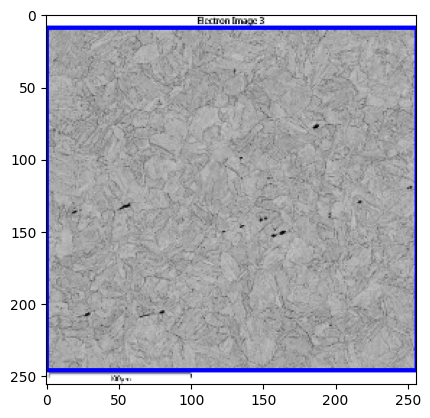

In [13]:
draw_bbox_on_image(X_train_scaled[0],normalize_to_absolute_boxes(Y[0])[0])

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Reshape, Concatenate, Conv2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

def create_ssd_model(num_classes, img_size=(256, 256, 3)):
    base_model = MobileNetV2(input_shape=img_size, include_top=False, weights='imagenet')
    base_model.trainable = False  # Freeze the base model

    model = tf.keras.Sequential([
        base_model,
        GlobalAveragePooling2D(),  # Réduire les dimensions pour la couche Dense
        Dense(4, activation='sigmoid')  # Spécifier l'activation pour la prédiction des coordonnées
    ])

    return model



2024-03-06 17:48:45.154546: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [15]:
# Création du modèle
model = create_ssd_model(num_classes=1)  # num_classes n'est plus utilisé ici

# Compiler le modèle
model.compile(optimizer='adam', loss='mse', metrics=['mae'] )

model.summary()

2024-03-06 17:48:49.090121: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-03-06 17:48:49.120570: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-03-06 17:48:49.120871: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1060 6GB computeCapability: 6.1
coreClock: 1.7335GHz coreCount: 10 deviceMemorySize: 5.93GiB deviceMemoryBandwidth: 178.99GiB/s
2024-03-06 17:48:49.120904: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-03-06 17:48:49.130062: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-03-06 17:48:49.130160: I tensorflow/stream_executo

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 8, 8, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 4)                 5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
Y_reshaped = Y.reshape(-1,1,4)  # Change la forme de (62, 1, 4) à (62, 4)
Y = Y.reshape(-1,4)  # Change la forme de (62, 1, 4) à (62, 4)

In [75]:
history = model.fit(X_train_scaled, Y, epochs=50, batch_size=16, validation_split=0.1)

Epoch 1/50
15/15 [==============================] - 1s 59ms/step - loss: 6.0916e-05 - mae: 0.0049 - val_loss: 0.0013 - val_mae: 0.0145
Epoch 2/50
15/15 [==============================] - 1s 52ms/step - loss: 6.0978e-05 - mae: 0.0050 - val_loss: 0.0013 - val_mae: 0.0145
Epoch 3/50
15/15 [==============================] - 1s 50ms/step - loss: 6.0224e-05 - mae: 0.0049 - val_loss: 0.0013 - val_mae: 0.0144
Epoch 4/50
15/15 [==============================] - 1s 50ms/step - loss: 5.9296e-05 - mae: 0.0049 - val_loss: 0.0013 - val_mae: 0.0144
Epoch 5/50
15/15 [==============================] - 1s 51ms/step - loss: 5.8615e-05 - mae: 0.0048 - val_loss: 0.0013 - val_mae: 0.0145
Epoch 6/50
15/15 [==============================] - 1s 51ms/step - loss: 5.8102e-05 - mae: 0.0048 - val_loss: 0.0013 - val_mae: 0.0145
Epoch 7/50
15/15 [==============================] - 1s 49ms/step - loss: 5.7770e-05 - mae: 0.0048 - val_loss: 0.0013 - val_mae: 0.0145
Epoch 8/50
15/15 [==============================] - 1s 

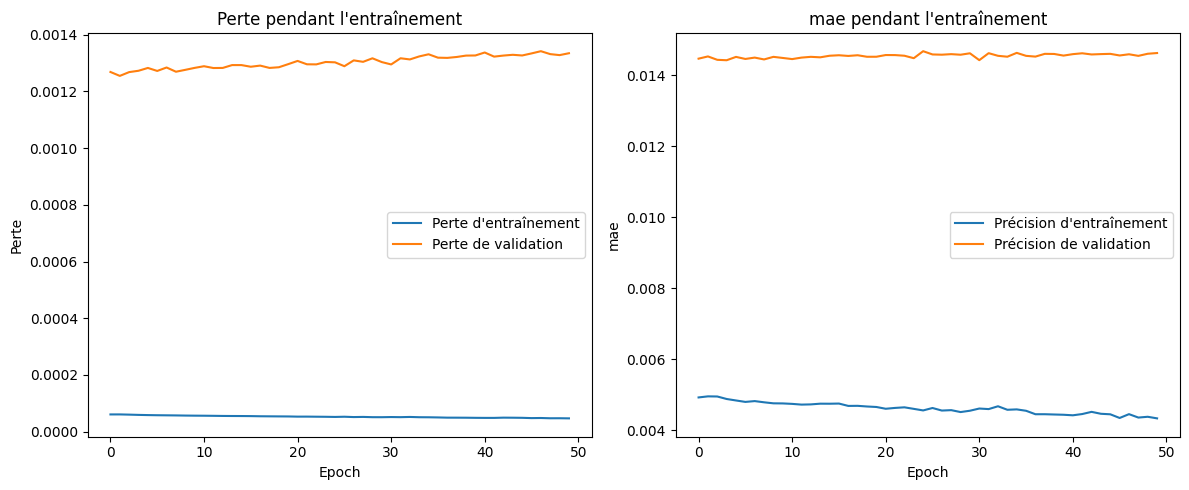

In [76]:
# Afficher les courbes d'entraînement
plt.figure(figsize=(12, 5))

# Affichage de la perte
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Perte d\'entraînement')
plt.plot(history.history['val_loss'], label='Perte de validation')
plt.title('Perte pendant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('Perte')
plt.legend()

# Affichage de la précision
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Précision d\'entraînement')
plt.plot(history.history['val_mae'], label='Précision de validation')
plt.title('mae pendant l\'entraînement')
plt.xlabel('Epoch')
plt.ylabel('mae')
plt.legend()

plt.tight_layout()
plt.show()

In [80]:
test_image = X_train_scaled[93]  # Prendre la première image pour l'exemple

# Prédire la bounding box
# Ajoutez une nouvelle dimension et prenez la première prédiction
pred_box = model.predict(np.expand_dims(test_image, axis=0)) 

bbx = normalize_to_absolute_boxes(pred_box)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


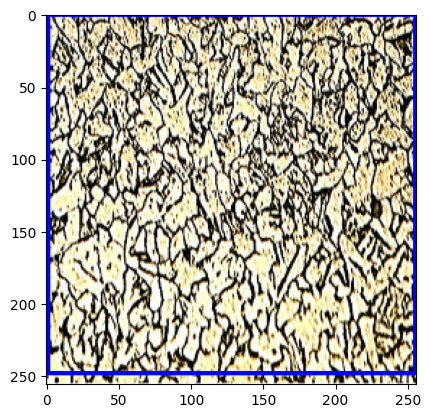

In [81]:
draw_bbox_on_image(test_image,bbx)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


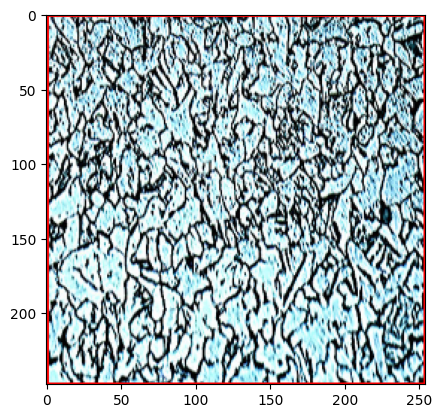

In [82]:
# Exemple d'utilisation
# Supposons que `image` est votre image d'entrée (numpy array) et `bbox` sont les coordonnées absolues de votre boîte englobante
image_cropped = crop_image_to_bbox(test_image, bbx)

# Affichez l'image croppée
plt.imshow(image_cropped)
plt.show()

In [25]:
def prepare_image_for_prediction(image_path, target_size=(256, 256)):

    from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
    """
    Charge et prépare une image extérieure pour la prédiction par un modèle.

    :param image_path: Chemin vers l'image à charger.
    :param target_size: Taille cible à laquelle l'image doit être redimensionnée.
    :return: Une image prête pour la prédiction, avec le prétraitement appliqué.
    """
    # Charger l'image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    
    # Redimensionner l'image à la taille cible
    image_resized = cv2.resize(image, target_size)
    
    # Convertir l'image de BGR (format OpenCV) en RGB
    image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    
    # Appliquer le prétraitement spécifique à MobileNetV2 (cela normalise les pixels)
    image_preprocessed = preprocess_input(image_rgb)
    
    # Ajouter une dimension de lot à l'image
    image_batch = np.expand_dims(image_preprocessed, axis=0)
    
    return image_batch

In [83]:
# Exemple d'utilisation
image_path = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/test/test2.png'  # Remplacez cela par le chemin de votre image
image_for_prediction = prepare_image_for_prediction(image_path)

# Maintenant, `image_for_prediction` est prête à être passée au modèle pour une prédiction


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


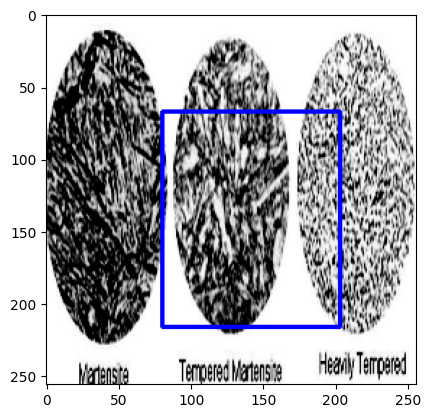

In [84]:
pred_box = model.predict(image_for_prediction) 

bbx = normalize_to_absolute_boxes(pred_box)[0]

draw_bbox_on_image(image_for_prediction.reshape(256,256,3),bbx)

In [40]:
model.save('img_det2.h5')

########################################################################################################

In [43]:
from tensorflow.keras.models import load_model
model = load_model('/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/Models/img_det2.h5')

In [66]:
target_size=(256,256)

image = cv2.imread('/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_microstructure_png/converted_7.png', cv2.IMREAD_COLOR)
    
# Redimensionner l'image à la taille cible
image_resized = cv2.resize(image, target_size)
    
# Convertir l'image de BGR (format OpenCV) en RGB (format TensorFlow)
image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
    
# Appliquer le prétraitement spécifique à MobileNetV2
# Cela normalise les pixels de l'image selon les besoins de MobileNetV2
image_preprocessed = preprocess_input(image_rgb)
    
# Ajouter une dimension de lot à l'image pour qu'elle corresponde à l'input attendu par le modèle ('batch_size', hauteur, largeur, canaux)
image_batch = np.expand_dims(image_preprocessed, axis=0)

In [67]:
# Prédire la bounding box
# Ajoutez une nouvelle dimension et prenez la première prédiction
pred_box = model.predict(image_batch) 

bbx = normalize_to_absolute_boxes(pred_box)[0]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


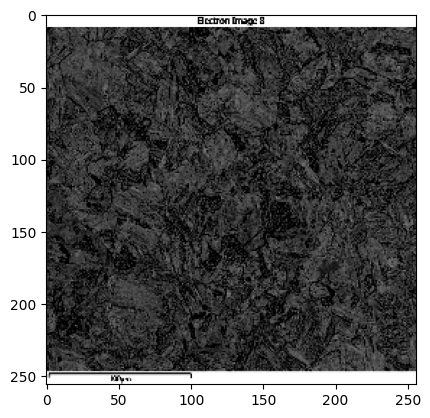

In [68]:
plt.imshow(image_batch.reshape(256,256,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


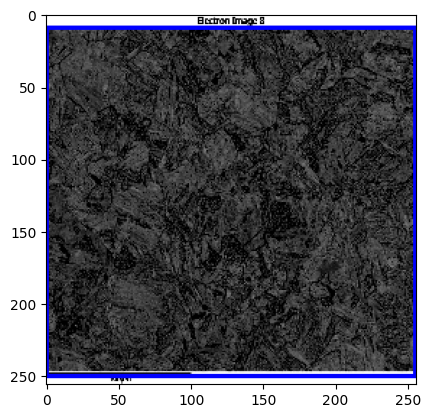

In [69]:
draw_bbox_on_image(image_batch.reshape(256,256,3),bbx)

In [70]:
import os
import cv2
import numpy as np

def manual_preprocess_input(image):
    """
    Normalise les images dans la plage [-1, 1].
    """
    return image / 127.5 - 1

def crop_and_save_predicted_images_folder(image_dir, output_dir, model, target_size=(256, 256)):
    """
    Charge toutes les images d'un dossier, applique un modèle pour prédire les boîtes englobantes,
    crope ces images selon les boîtes englobantes prédites, et sauvegarde les images croppées dans un dossier de sortie.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.png')]
    
    for image_file in image_files:
        image_path = os.path.join(image_dir, image_file)
        output_image_path = os.path.join(output_dir, image_file)
        
        # Charger l'image
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        
        # Redimensionner l'image à la taille cible
        image_resized = cv2.resize(image, target_size)
        
        # Convertir l'image de BGR en RGB
        image_rgb = cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB)
        
        # Appliquer un prétraitement manuel pour normaliser les pixels
        image_preprocessed = manual_preprocess_input(image_rgb)
        
        # Ajouter une dimension de lot à l'image
        image_batch = np.expand_dims(image_preprocessed, axis=0)
        
        # Appliquer le modèle pour obtenir les boîtes prédites
        pred_boxes_normalized = model.predict(image_batch)
        pred_boxes = normalize_to_absolute_boxes(pred_boxes_normalized, target_size)
        
        # Pour chaque boîte englobante prédite, croper l'image et la sauvegarder
        for i, bbox in enumerate(pred_boxes):
            cropped_image = crop_image_to_bbox(image_resized, bbox)  # Utiliser `image_resized` pour croper
            cropped_image_path = output_image_path.replace('.png', f'_crop_{i}.png')
            cv2.imwrite(cropped_image_path, cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR))  # Convertir RGB en BGR pour la sauvegarde
            print(f"Cropped and saved: {cropped_image_path}")


In [71]:
image_dir = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_microstructure_png'
output_dir = '/home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_cleaned_with_bbox_pred'
crop_and_save_predicted_images_folder(image_dir,output_dir,model)

Cropped and saved: /home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_cleaned_with_bbox_pred/converted_B2_crop_0.png
Cropped and saved: /home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_cleaned_with_bbox_pred/converted_converted_Image_54_crop_0.png
Cropped and saved: /home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_cleaned_with_bbox_pred/converted_converted_Image_24_crop_0.png
Cropped and saved: /home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_cleaned_with_bbox_pred/converted_C7_crop_0.png
Cropped and saved: /home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_cleaned_with_bbox_pred/converted_C12_crop_0.png
Cropped and saved: /home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/dataset-full/martensite_cleaned_with_bbox_pred/converted_19_crop_0.png
Cropped and saved: /home/riccardo/Visual_Studio_Code/Grain-segmentation_prjt/da

In [3]:
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.24 🚀 Python-3.9.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6070MiB)
Setup complete ✅ (4 CPUs, 15.6 GB RAM, 324.2/915.3 GB disk)


In [12]:
!yolo predict model=yolov8n.pt source='/home/riccardo/Desktop/Untitled Folder/martensitemicrostructure9.png'

Ultralytics YOLOv8.1.24 🚀 Python-3.9.18 torch-2.2.1+cu121 CUDA:0 (NVIDIA GeForce GTX 1060 6GB, 6070MiB)
YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

libpng warning: iCCP: profile 'ICC Profile': 0h: PCS illuminant is not D50
image 1/1 /home/riccardo/Desktop/Untitled Folder/martensitemicrostructure9.png: 352x640 (no detections), 61.3ms
Speed: 2.1ms preprocess, 61.3ms inference, 19.7ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict7
💡 Learn more at https://docs.ultralytics.com/modes/predict


In [7]:
/home/riccardo/Desktop/Untitled Folder/martensite32.jpeg

NameError: name 'home' is not defined

In [ ]:
martensite38.jpeg
martensite39.jpeg
martensitegrain26.png
martensitegrain28.png
martensitegrain31.jpeg
martensitemicrostructure2.jpeg
martensitemicrostructure9.png
martensitemicrostructure20.jpeg